![](pics/header-2.png)

# Calibration with Markers

An ArUco marker is a synthetic square marker composed by a wide black border and a inner binary matrix which determines its identifier (id). The black border facilitates its fast detection in the image and the binary codification allows its identification and the application of error detection and correction techniques. The marker size determines the size of the internal matrix. For instance a marker size of 4x4 is composed by 16 bits.

The ArUco module can be used to calibrate a camera. Camera calibration consists in obtaining the camera intrinsic parameters and distortion coefficients. Camera calibration is usually performed using the OpenCV `calibrateCamera()` function. This function requires some correspondences between environment points and their projection in the camera image from different viewpoints. In general, these correspondences are obtained from the corners of chessboard patterns. Calibrating using ArUco is much more versatile than using traditional chessboard patterns, since it allows occlusions or partial views.

![](pics/charucodefinition.png)

ChArUco boards combine ArUco markers with a standard checkerboard. ChArUco board corners provide much more accuratacy in comparison to the ArUco marker corners. Calibration using a standard Board should only be employed in those scenarios where the ChArUco boards cannot be employed because of any kind of restriction.

## References

- [OpenCV 4.0: ArUco Tutorials](https://docs.opencv.org/4.0.0/d9/d6d/tutorial_table_of_content_aruco.html)
- [Automatic generation and detection of highly reliable fiducial markers under occlusion](docs/paper-2014.pdf)
- [Notes using aruco markers](https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/sandbox/ludovic/aruco_calibration_rotation.html)

## Contents

- [Stereo Calibration](#stereo-calibration)
- [ChArUco Target Board](#charuco-target-board)
- [Get Calibration Images](#get-calibration-images)
- [Camera Intrinsics](#camera-intrinsics)
- [Camera Extrinsics](#camera-extrinsics)
- [Yaml](#yaml)
- Appendix A: Calibration
- Appendix B: Blurry

# Stereo Calibration

1. Let's calibrate each camera individually and find its intrinsic parameters
2. Use this data to then calibrate the two cameras together and find their extrinsic parameters

In [1]:
# reload library
%load_ext autoreload
%autoreload 2

In [56]:
import numpy as np
import cv2
import cv2.aruco as aruco
from matplotlib import pyplot as plt
from opencv_camera import StereoCamera
from opencv_camera import coverage
from opencv_camera import visualizeDistortion
from opencv_camera import drawEpipolarLines
from opencv_camera import mosaic
from colorama import Fore

from helpers import blurry
from helpers import Calibrate
from helpers import get_images

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# ChArUco Target Board

## Dictionary

The markers are generated according to a *dictionary* which defines the number of horizontal and vertical bits for each marker and the total number of valid values that are contained. For example, `aruco.DICT_4X4_50` defines a 4x4 2D marker with 50 unique marker ids in it. Once the dictionary is created, individual markers can be drawn.

```python
dictionary = aruco.Dictionary_get(aruco.DICT_4X4_50)
dictionary.drawMarker(id, sidePixels[, _img[, borderBits]]) -> _img
```

## Boards

The board structure has the following useful members/methods:

- `chessboardCorners`
- `create`
- `dictionary`
- `draw`
- `getChessboardSize`
- `getMarkerLength`
- `getSquareLength`
- `ids`
- `nearestMarkerCorners`
- `nearestMarkerIdx`
- `objPoints`

Found markers can be drawn on an image using `aruco.drawDetectedMarkers(img, corners, ids)`.

True

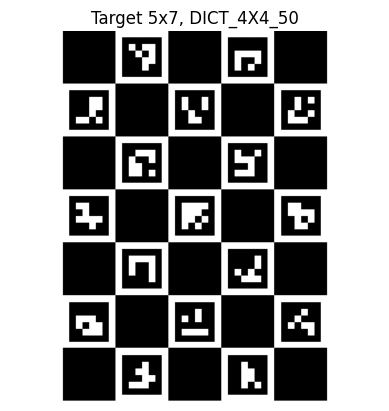

In [4]:
dictionary = aruco.Dictionary_get(aruco.DICT_4X4_50)
x = 5  # horizontal
y = 7  # vertical
sqr = 0.014  # solid black squares
mrk = 0.0105 # markers, must be smaller than squares

board = aruco.CharucoBoard_create(
    x,y,
    sqr,
    mrk,
    dictionary)

tgt = board.draw((1000,1000))

plt.imshow(tgt, cmap="gray")
plt.axis("off")
plt.title("Target 5x7, DICT_4X4_50");

cv2.imwrite("board.png", tgt)

## Get Calibration Images

In [57]:
# the left/right images are stored together as one image. We
# need to read in each image and cut it in half to separate out
# the left/right
imgsL, imgsR = get_images("aruco-imgs-2/*.png")

Found 60 images at aruco-imgs-2/*.png


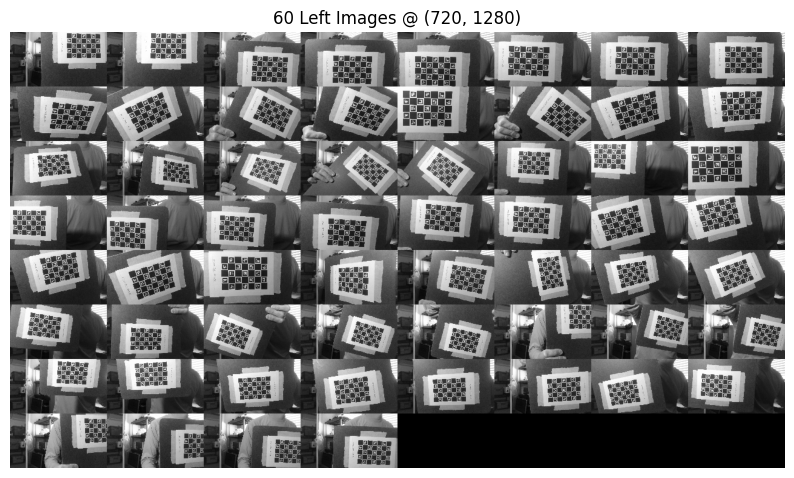

In [63]:
plt.figure(figsize=(10,10))
mos = mosaic(imgsL)
plt.imshow(mos, cmap="gray")
plt.title(f"{len(imgsL)} Left Images @ {imgsL[0].shape}")
plt.axis("off");

In [8]:
# Ideally we don't want any blurry images getting into the dataset
for i, (l, r) in enumerate(zip(imgsL, imgsR)):
    thres = 200
    blurl, vall = blurry(l, thres)
    cl = Fore.RED if blurl is True else ""
    blurr, valr = blurry(r, thres)
    cr = Fore.RED if blurr is True else ""
    
    if blurl or blurr:
        print(f"{cl}{i:3}: left: {blurl},{vall}{Fore.RESET}", end="   ")
        print(f"{cr}right: {blurr},{valr}{Fore.RESET}", end="   ")
        print(f"threshold ratio: {(vall - thres)/thres:.2f} / {(valr - thres)/thres:.2f}")

  7: left: False,217   right: True,156   threshold ratio: 0.09 / -0.22
  8: left: False,255   right: True,194   threshold ratio: 0.28 / -0.03
  9: left: False,243   right: True,180   threshold ratio: 0.21 / -0.10
 12: left: False,259   right: True,130   threshold ratio: 0.29 / -0.35
 14: left: False,285   right: True,192   threshold ratio: 0.42 / -0.04
 23: left: False,279   right: True,120   threshold ratio: 0.40 / -0.40
 33: left: False,283   right: True,175   threshold ratio: 0.41 / -0.12
 34: left: False,289   right: True,188   threshold ratio: 0.45 / -0.06
 35: left: False,240   right: True,188   threshold ratio: 0.20 / -0.06
 57: left: True,196   right: False,284   threshold ratio: -0.02 / 0.42


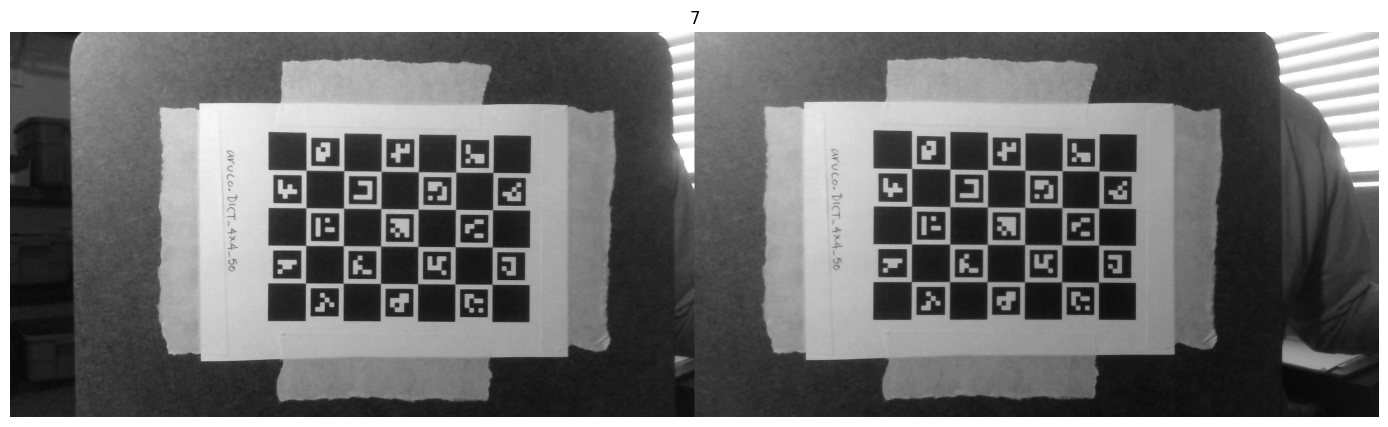

In [9]:
# I think background is giving blurry warnings, not calibration target
num = 7
plt.figure(figsize=(20,5))
plt.imshow(np.hstack((imgsL[num], imgsR[num])), cmap="gray")
plt.axis("off")
plt.title(num);

# Camera Intrinsics

In [11]:
# left camera parameters
cal = Calibrate(dictionary, board)
rms1, M1, d1, r1, t1, objpoints, imgpoints_l = cal.calibrate(imgsL)
# print(len(objpoints), objpoints[0].shape, len(imgpoints_l), imgpoints_l[0].shape)

RMS: 0.2177539509799831 px
Camera Matrix: [[1064.946    0.     627.131]
 [   0.    1064.585  369.801]
 [   0.       0.       1.   ]]
Dist Coeffs: [[ 0.119 -0.539  0.     0.001  0.704]]


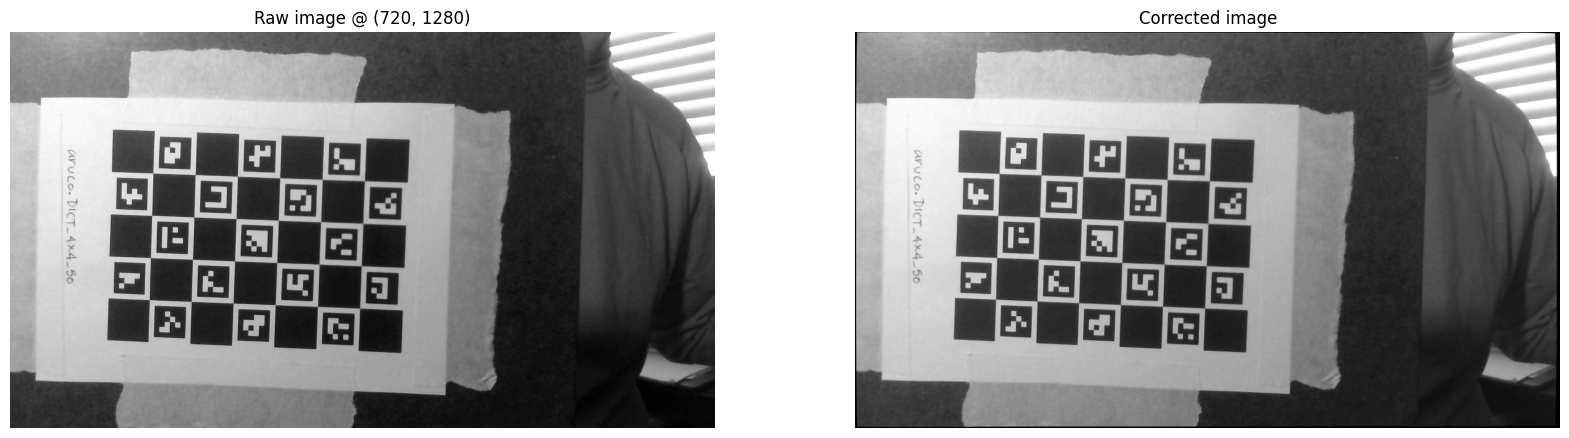

In [12]:
print('RMS:', rms1, 'px')
print('Camera Matrix:', M1)
print('Dist Coeffs:', d1)

i=5 # select image id
plt.figure(figsize=(20,10))
img_undist = cv2.undistort(imgsL[i],M1,d1,None)
plt.subplot(1,2,1)
plt.imshow(imgsL[i], cmap='gray')
plt.title("Raw image @ {}".format(imgsL[i].shape))
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist, cmap='gray')
plt.title("Corrected image")
plt.axis("off");

In [13]:
# right camera parameters
rms2, M2, d2, r2, t2, objpoints, imgpoints_r = cal.calibrate(imgsR)

RMS: 0.2155775919809732 px
Camera Matrix: [[1056.75     0.     631.   ]
 [   0.    1056.451  366.532]
 [   0.       0.       1.   ]]
Dist Coeffs: [[ 0.123 -0.592  0.001 -0.002  0.834]]


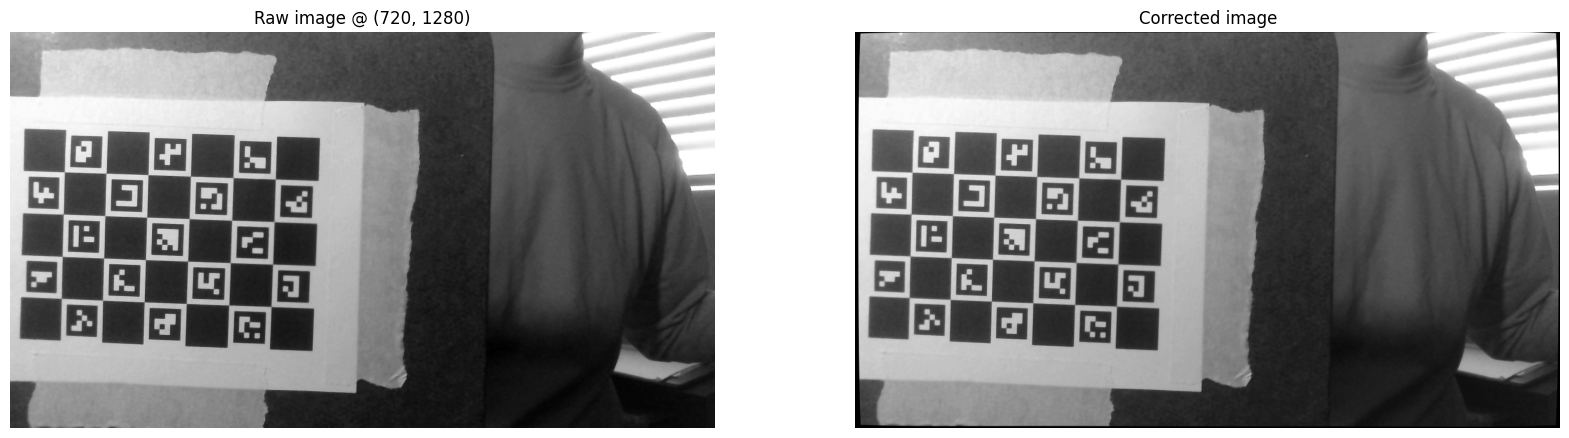

In [14]:
print('RMS:', rms2, 'px')
print('Camera Matrix:', M2)
print('Dist Coeffs:', d2)

i=5 # select image id
plt.figure(figsize=(20,10))
img_undist = cv2.undistort(imgsR[i],M2,d2,None)
plt.subplot(1,2,1)
plt.imshow(imgsR[i], cmap='gray')
plt.title("Raw image @ {}".format(imgsR[i].shape))
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist, cmap='gray')
plt.title("Corrected image")
plt.axis("off");

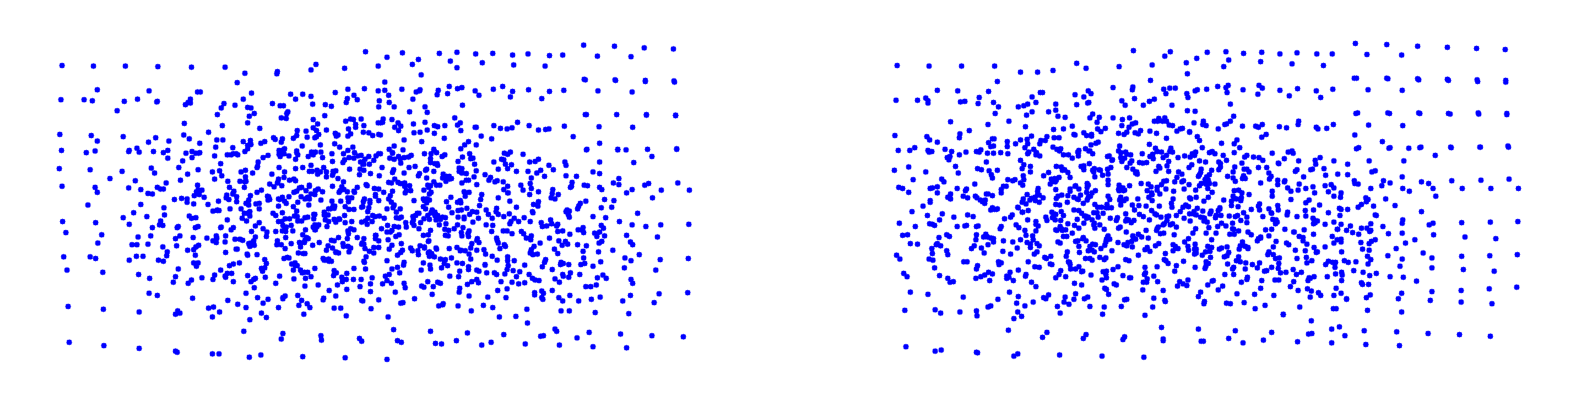

In [17]:
# draw image points mapped across camera focal plane
plt.figure(figsize=(20,10))
plt.subplot(121);plt.imshow(coverage(imgsL[0].shape[:2], np.vstack(imgpoints_l)));plt.axis("off");
plt.subplot(122);plt.imshow(coverage(imgsR[0].shape[:2], np.vstack(imgpoints_r)));plt.axis("off");

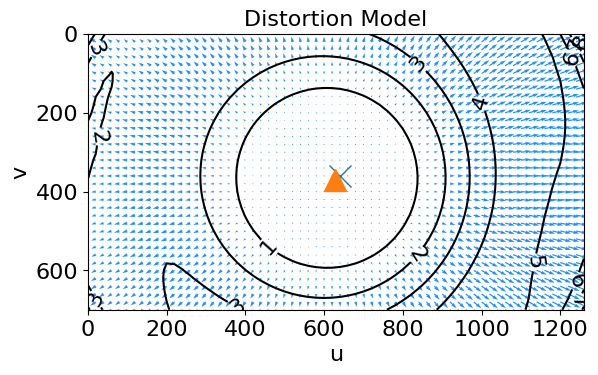

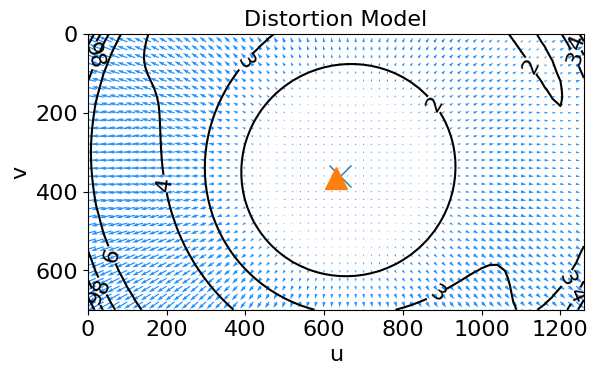

In [18]:
h,w = imgsL[0].shape[:2]
visualizeDistortion(M1, d1, h, w)

h,w = imgsR[0].shape[:2]
visualizeDistortion(M2, d2, h, w);

In [64]:
# eimg = drawEpipolarLines(imgpoints_l[0],imgpoints_r[0],imgsL[0],imgsR[0])

# Camera Extrinsics

In [20]:
# some markers are obscured, we need to weed out the
# points that are not in BOTH the left and right images
objpts = []
rpts = []
lpts = []
for o,l,r in zip(objpoints,imgpoints_l,imgpoints_r):
    # must have all the same number of points for calibration
    if o.shape[:2] == l.shape[:2] == r.shape[:2]:
        objpts.append(o)
        rpts.append(r)
        lpts.append(l)
    else:
        print("bad points:", o.shape, l.shape, r.shape)

bad points: (24, 1, 3) (24, 1, 2) (16, 1, 2)
bad points: (24, 1, 3) (24, 1, 2) (16, 1, 2)
bad points: (24, 1, 3) (24, 1, 2) (16, 1, 2)
bad points: (24, 1, 3) (24, 1, 2) (16, 1, 2)
bad points: (24, 1, 3) (24, 1, 2) (16, 1, 2)
bad points: (24, 1, 3) (24, 1, 2) (22, 1, 2)
bad points: (24, 1, 3) (24, 1, 2) (22, 1, 2)
bad points: (24, 1, 3) (16, 1, 2) (24, 1, 2)
bad points: (24, 1, 3) (16, 1, 2) (24, 1, 2)
bad points: (24, 1, 3) (16, 1, 2) (24, 1, 2)
bad points: (24, 1, 3) (17, 1, 2) (24, 1, 2)


In [48]:
print('obj pts', len(objpts))
print('imgpoints left', len(lpts))
print('imgpoints right', len(rpts))

flags = 0
# flags |= cv2.CALIB_FIX_INTRINSIC
# flags |= cv2.CALIB_FIX_PRINCIPAL_POINT
flags |= cv2.CALIB_USE_INTRINSIC_GUESS
# flags |= cv2.CALIB_FIX_FOCAL_LENGTH
flags |= cv2.CALIB_ZERO_DISPARITY
# flags |= cv2.CALIB_FIX_ASPECT_RATIO
# flags |= cv2.CALIB_ZERO_TANGENT_DIST
# flags |= cv2.CALIB_RATIONAL_MODEL
# flags |= cv2.CALIB_SAME_FOCAL_LENGTH
# flags |= cv2.CALIB_FIX_K3
# flags |= cv2.CALIB_FIX_K4
# flags |= cv2.CALIB_FIX_K5

stereocalib_criteria = (
    cv2.TERM_CRITERIA_MAX_ITER +
    cv2.TERM_CRITERIA_EPS, 
    100, 
    1e-5)

h, w = imgsL[0].shape[:2]

ret, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate(
    objpts,
    lpts,
    rpts,
    M1, d1,
    M2, d2,
    (w,h),
    criteria=stereocalib_criteria,
    flags=flags)

print('-'*50)
# print('Image: {}x{}'.format(*imgs_l[0].shape[:2]))
# print('{}: {}'.format(marker_type, marker_size))
print('Intrinsic Camera Parameters')
print('-'*50)
print(' [Camera 1]')
# print('  cameraMatrix_1', M1)
print('  f(x,y): {:.1f} {:.1f} px'.format(M1[0,0], M1[1,1]))
print('  principlePoint(x,y): {:.1f} {:.1f} px'.format(M1[0,2], M1[1,2]))
print('  distCoeffs', d1[0])
print(' [Camera 2]')
# print('  cameraMatrix_2', M2)
print('  f(x,y): {:.1f} {:.1f} px'.format(M2[0,0], M2[1,1]))
print('  principlePoint(x,y): {:.1f} {:.1f} px'.format(M2[0,2], M2[1,2]))
print('  distCoeffs', d2[0])
print('-'*50)
print('Extrinsic Camera Parameters')
print('-'*50)
print(' Rotation between left/right camera\n', R)
print(' Translation between left/right camera[meter]', T.T)
print(' Essential matrix\n', E)
print(' Fundamental matrix\n', F)

obj pts 49
imgpoints left 49
imgpoints right 49
--------------------------------------------------
Intrinsic Camera Parameters
--------------------------------------------------
 [Camera 1]
  f(x,y): 1061.4 1060.8 px
  principlePoint(x,y): 626.2 368.0 px
  distCoeffs [ 0.123 -0.545  0.     0.001  0.657]
 [Camera 2]
  f(x,y): 1059.1 1058.6 px
  principlePoint(x,y): 629.4 368.4 px
  distCoeffs [ 0.121 -0.528  0.002 -0.002  0.634]
--------------------------------------------------
Extrinsic Camera Parameters
--------------------------------------------------
 Rotation between left/right camera
 [[ 1.     0.001  0.   ]
 [-0.001  1.    -0.002]
 [-0.     0.002  1.   ]]
 Translation between left/right camera[meter] [[-0.03 -0.   -0.  ]]
 Essential matrix
 [[-0.    0.   -0.  ]
 [-0.    0.    0.03]
 [ 0.   -0.03  0.  ]]
 Fundamental matrix
 [[-0.     0.    -0.021]
 [-0.     0.     2.542]
 [ 0.025 -2.54   1.   ]]


In [46]:
# just playing around with calculating the fundamental matrix
from opencv_camera import findFundamentalMat

ff = findFundamentalMat(M1,M2,R,T, True)
print(ff)
print(ff/ff[2,2]) # what is above

[[-0.     0.    -0.006]
 [-0.     0.     0.681]
 [ 0.007 -0.681  0.268]]
[[-0.     0.    -0.021]
 [-0.     0.     2.542]
 [ 0.025 -2.54   1.   ]]


In [22]:
sc = StereoCamera(M1,d1,M2,d2,R,T.T,F,E)

print(sc)

Camera 1 --------------------------
  focalLength(x,y): 1061.4 1060.8 px 
  principlePoint(x,y): 626.2 368.0 px
  distortionCoeffs: [[ 0.123 -0.545  0.     0.001  0.657]]
Camera 2 --------------------------
  focalLength(x,y): 1059.1 1058.6 px 
  principlePoint(x,y): 629.4 368.4 px
  distortionCoeffs: [[ 0.121 -0.528  0.002 -0.002  0.634]]
Extrinsic Camera Parameters -------
  Translation between Left/Right Camera: [[-0.03 -0.   -0.  ]]
  Rotation between Left/Right Camera:
    [[ 1.     0.001  0.   ]
     [-0.001  1.    -0.002]
     [-0.     0.002  1.   ]]
  Essential Matrix:
    [[-0.    0.   -0.  ]
     [-0.    0.    0.03]
     [ 0.   -0.03  0.  ]]
  Fundatmental Matrix:
    [[-0.     0.    -0.021]
     [-0.     0.     2.542]
     [ 0.025 -2.54   1.   ]]



# Yaml

In [23]:
sc.to_yaml("camera.yml")

In [24]:
!cat camera.yml

E:
- - -2.8174899947524255e-08
  - 2.7415304916809837e-05
  - -0.0002389032952606705
- - -2.9212397965334014e-05
  - 6.218118030504189e-05
  - 0.029815735359773356
- - 0.00028005159676246666
  - -0.02981537793335913
  - 6.223120966939518e-05
F:
- - -2.262335840319361e-09
  - 2.2025548484713277e-06
  - -0.021169044301383725
- - -2.346799992156949e-06
  - 4.998121271549909e-06
  - 2.541864877098067
- - 0.024681676944747176
  - -2.5401263981000346
  - 1.0
K1:
- - 1061.3562964122361
  - 0.0
  - 626.1944932559309
- - 0.0
  - 1060.7724755609368
  - 367.95849020503454
- - 0.0
  - 0.0
  - 1.0
K2:
- - 1059.0809033118926
  - 0.0
  - 629.4252940998015
- - 0.0
  - 1058.5587364517041
  - 368.4308171719573
- - 0.0
  - 0.0
  - 1.0
R:
- - 0.9999990440508459
  - 0.0013821155265650302
  - 4.0670203258133864e-05
- - -0.0013820276450845317
  - 0.9999968674960928
  - -0.002086863098059504
- - -4.355436174818837e-05
  - 0.002086804895779257
  - 0.9999978216717997
T:
- - -0.02981580144363504
  - -0.000238845

In [25]:
mm = StereoCamera.from_yaml("camera.yml")
print(mm)

Camera 1 --------------------------
  focalLength(x,y): 1061.4 1060.8 px 
  principlePoint(x,y): 626.2 368.0 px
  distortionCoeffs: [[ 0.123 -0.545  0.     0.001  0.657]]
Camera 2 --------------------------
  focalLength(x,y): 1059.1 1058.6 px 
  principlePoint(x,y): 629.4 368.4 px
  distortionCoeffs: [[ 0.121 -0.528  0.002 -0.002  0.634]]
Extrinsic Camera Parameters -------
  Translation between Left/Right Camera: [[-0.03 -0.   -0.  ]]
  Rotation between Left/Right Camera:
    [[ 1.     0.001  0.   ]
     [-0.001  1.    -0.002]
     [-0.     0.002  1.   ]]
  Essential Matrix:
    [[-0.    0.   -0.  ]
     [-0.    0.    0.03]
     [ 0.   -0.03  0.  ]]
  Fundatmental Matrix:
    [[-0.     0.    -0.021]
     [-0.     0.     2.542]
     [ 0.025 -2.54   1.   ]]



In [26]:
print(mm.p1())
print(mm.p2())

[[1061.356    0.     626.194    0.   ]
 [   0.    1060.772  367.958    0.   ]
 [   0.       0.       1.       0.   ]]
[[1059.052    2.777  629.467  -31.595]
 [  -1.479 1059.324  366.221   -0.263]
 [  -0.       0.002    1.      -0.   ]]


# Appendix A: Camera Intrinsic Calibration Code

In [29]:
from jtb import getCodeUrl, getCodeFile, getCodeImport

In [30]:
getCodeImport(Calibrate)

# Appendix B: Blurry

In [31]:
getCodeImport(blurry)